load a pretrained model

In [24]:
import torch
import models
MODEL = 'fc_res'
CODED_SIZE = 64
PATCH_SIZE = 16
BATCH_SIZE = 1
NUM_PASSES= 32

class Args:
    def __init__(self, model, coded_size, patch_size, num_passes, batch_size):
        self.model = model
        self.coded_size = coded_size
        self.patch_size = patch_size
        self.num_passes = num_passes
        self.batch_size = batch_size
args = Args(model=MODEL,
            coded_size=CODED_SIZE,
            patch_size=PATCH_SIZE,
            num_passes=NUM_PASSES,
            batch_size=BATCH_SIZE)

model = models.setup(args)
print("ok")

model.load_state_dict(torch.load('./saved_models/fc_res-p16_b64-1_25.pkl'))

ok


<All keys matched successfully>

# get a trainset

In [32]:
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Subset, DataLoader

seed = 42
torch.manual_seed(seed)

# Normalize function so given an image of range [0, 1] transforms it into a Tensor range [-1. 1]
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR LOADER
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
# Generate random indices to select a subset
indices = torch.randperm(len(trainset)).tolist()[:50]
# Create a smaller dataset from the full dataset
trainset_small = Subset(trainset, indices)

train_loader_small = torch.utils.data.DataLoader(trainset_small, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


# write the eval function

In [54]:
import os
from torch.autograd import Variable
import matplotlib.pyplot as plt


def reconstruct_patches(patches):
    """
    :param patches:
    :return:
    """
    # Determine batch size and patch size from the first patch
    batch_size = patches[0].size(0)
    patch_size = patches[0].size(2)

    # Calculate the number of patches along one dimension
    num_patches_x = 32 // patch_size

    # Initialize an empty tensor for the reconstructed image
    reconstructed = torch.zeros(batch_size, 3, 32, 32)

    # Patch counter
    p = 0
    # Iterate through each position to place patches back into the reconstructed image
    for i in range(num_patches_x):
        for j in range(num_patches_x):
            # Assign each patch to its corresponding position in the reconstructed image
            reconstructed[:, :, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patches[p].data
            p += 1
    return reconstructed


def to_patches(x, patch_size):
    """
    Splits an input tensor into square patches of a specified size.

    :param x: (Tensor) The input tensor to be split into patches. Expected shape is (N, C, H, W).
    :param patch_size:(int) The size of one side of the square patches to be extracted.
    :return:patches - List[Tensor]: A list of the extracted patches, each of which is a tensor with shape (N, C, patch_size, patch_size).
    """
    # Calculate the number of patches along one dimension
    num_patches_x = 32//patch_size

    patches = []

    # Iterate over each patch position in the input tensor
    for i in range(num_patches_x):
        for j in range(num_patches_x):

            # Extract the patch
            patch = x[:, :, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]

            # Ensure the patch is contiguous in memory and add it to the list
            patches.append(patch.contiguous())
    return patches

def imsave(img, name, output_path = 'test_imgs/'):
    img = img / 2 + 0.5     # unnormalize
    saving_path = os.path.join(output_path, name+'.png')
    torchvision.utils.save_image(img, saving_path)

def imshow(img, name, output_path = 'test_imgs/'):
    img = img / 2 + 0.5     # unnormalize

    # Convert the tensor to a PIL image using torchvision.transforms
    to_pil_image = transforms.ToPILImage()
    img_pil = to_pil_image(img)

    # Display the image using matplotlib
    plt.imshow(img_pil)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

def evaluate(model, imgs =None, dataiter = None, num_samples =20,batch_size=4):
    for i in range(num_samples//batch_size):
        print(i)
        #load the datasd

        imgs, _ = next(dataiter)
        imsave(torchvision.utils.make_grid(imgs), 'prova_'+str(i))

        # divide the images to patches:
        patches = to_patches(imgs, args.patch_size)
        r_patches = []  # Reconstructed Patches

        # If the model is not a residual model, reset its state for a fresh start
        if args.residual is None:
            model.reset_state()

        # Process each patch through the model
        for p in patches:

            # If the model is a residual model, use the model's sampling method
            if args.residual:
                outputs = model.sample(Variable(p))

            # Otherwise, simply forward the patch through the model
            else:
                outputs = model(Variable(p))
            # Collect the model's output patches for reconstruction
            r_patches.append(outputs)
        # Transform the patches into the image
        outputs = reconstruct_patches(r_patches)
        imshow(torchvision.utils.make_grid(outputs), 'prova_'+str(i)+'_decoded')
        imshow(torchvision.utils.make_grid(imgs), 'prova_'+str(i))

        imsave(torchvision.utils.make_grid(outputs), 'prova_'+str(i)+'_decoded')



0


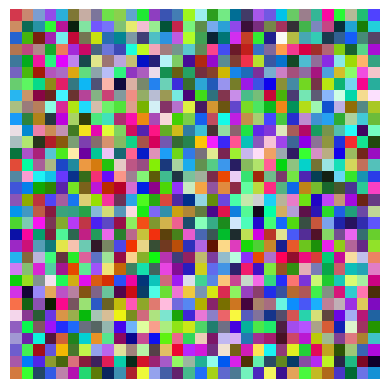

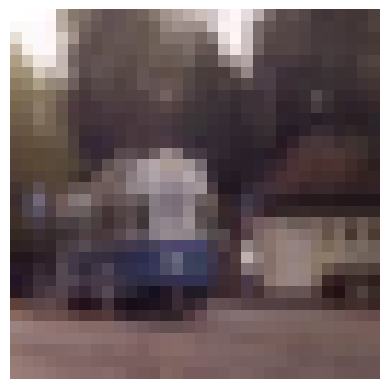

1


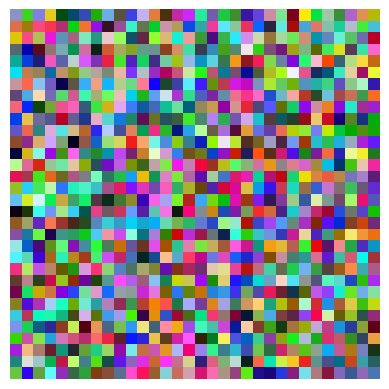

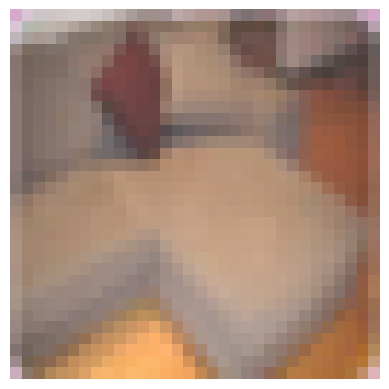

2


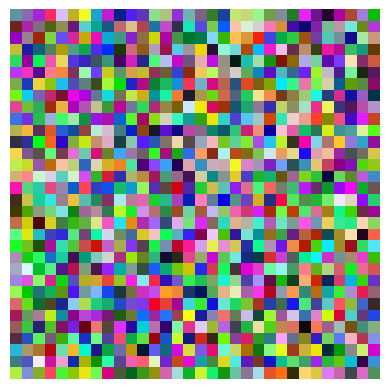

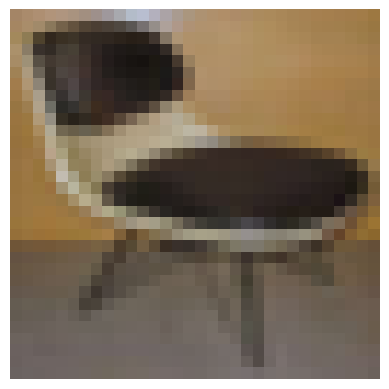

3


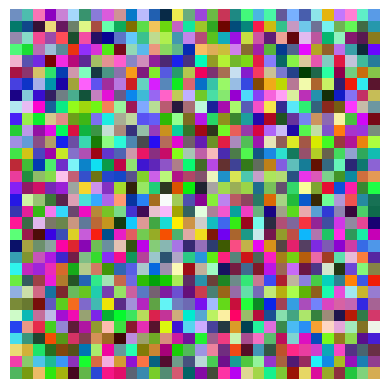

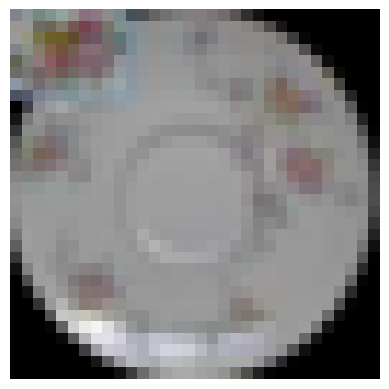

4


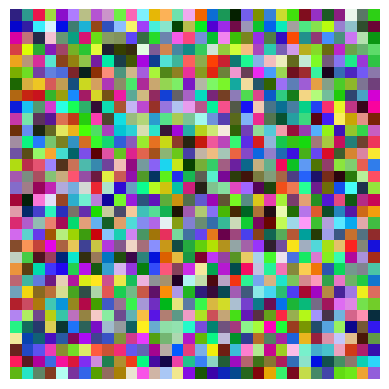

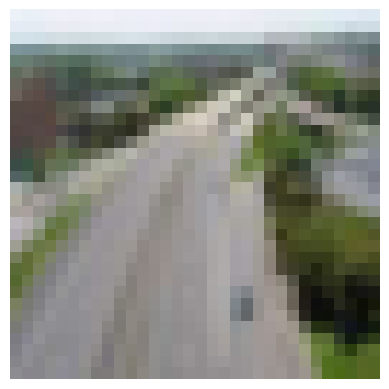

In [55]:
import torch
dataiter = iter(train_loader_small)
evaluate(model, dataiter=dataiter)

In [56]:
#frre